<a href="https://colab.research.google.com/github/nivanshi/Machine-Learning/blob/master/text_classification_using_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install torch===1.5.0 torchvision===0.6.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 752.0MB 23kB/s 
     |████████████████████████████████| 6.6MB 11.6MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from tqdm import tqdm
import time
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold,KFold, cross_val_score

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from sklearn import preprocessing, model_selection, pipeline
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import RepeatedKFold

In [5]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [6]:
from google.colab import files
uploaded = files.upload()

Saving fake_job_postings.csv to fake_job_postings.csv


In [8]:
fake=pd.read_csv("/content/fake_job_postings.csv")
fake.head()



,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


# New Section

In [0]:
fake.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [9]:
fake.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
fake.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

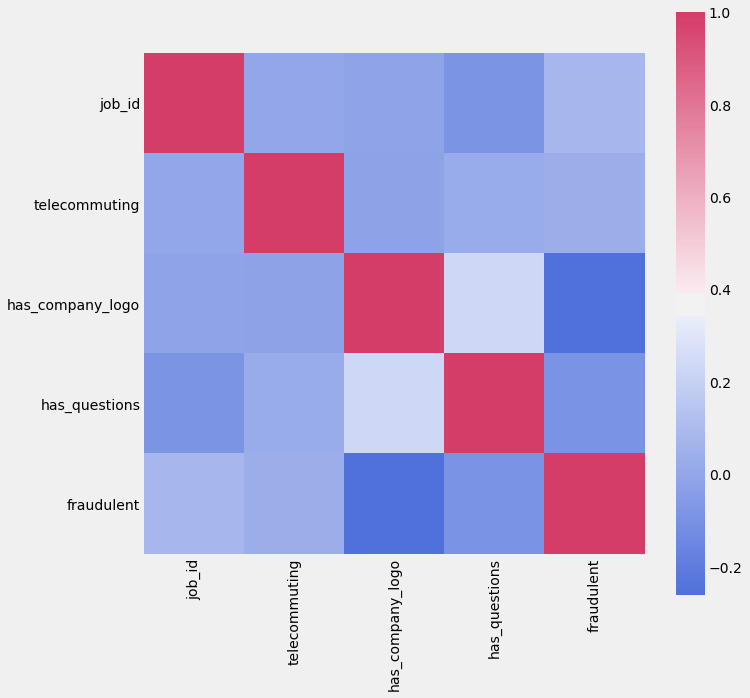

In [11]:
plt.figure(figsize=(10,10))
corr=fake.corr()
sns.heatmap(corr,mask=np.zeros_like(corr,dtype=np.bool),cmap=sns.diverging_palette(-100,0,as_cmap=True),square=True)

In [0]:
cols=["title","company_profile","description","requirements","benefits"]
for c in cols:
  fake[c]=fake[c].fillna(" ")

In [0]:
def extract_features(fake):
  for c in cols:
    fake[c+"_len"]=fake[c].apply(lambda x: len(str(x)))
    
    fake[c+"_wc"]=fake[c].apply(lambda x: len(str(x.split())))

In [0]:
extract_features(fake)

In [14]:
fake.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [0]:
fake['combined_text']=fake['company_profile']+" "+fake['description']+" "+fake["requirements"]+" "+fake["benefits"]

In [0]:
n_features={
    "title":100,
    "combined_text":500
}

In [0]:
for c,n in n_features.items():
  tfidf=TfidfVectorizer(max_features=n, norm='l2',stop_words="english")
  tfidf.fit(fake[c])
  tfidf_train=np.array(tfidf.transform(fake[c]).toarray(),dtype=np.float16)
  for i in range(n_features[c]):
    fake[c+"_tfidf_"+str(i)]=tfidf_train[:, i]

In [0]:
cat_cols=["employment_type","required_experience","required_education","industry","function"]
for c in cat_cols:
  encoded=pd.get_dummies(fake[c])
  fake=pd.concat([fake,encoded],axis=1)

In [19]:
drop_cols=['title','location','department','salary_range','company_profile','description','requirements','benefits','combined_text']
drop_cols+=cat_cols
fake=fake.drop(drop_cols,axis=1)
fake.head()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent,title_tfidf_0,title_tfidf_1,title_tfidf_2,title_tfidf_3,title_tfidf_4,title_tfidf_5,title_tfidf_6,title_tfidf_7,title_tfidf_8,title_tfidf_9,title_tfidf_10,title_tfidf_11,title_tfidf_12,title_tfidf_13,title_tfidf_14,title_tfidf_15,title_tfidf_16,title_tfidf_17,title_tfidf_18,title_tfidf_19,title_tfidf_20,title_tfidf_21,title_tfidf_22,title_tfidf_23,title_tfidf_24,title_tfidf_25,title_tfidf_26,title_tfidf_27,title_tfidf_28,title_tfidf_29,title_tfidf_30,title_tfidf_31,title_tfidf_32,title_tfidf_33,title_tfidf_34,...,Wine and Spirits,Wireless,Writing and Editing,Accounting/Auditing,Administrative,Advertising,Art/Creative,Business Analyst,Business Development,Consulting,Customer Service,Data Analyst,Design,Distribution,Education,Engineering,Finance,Financial Analyst,General Business,Health Care Provider,Human Resources,Information Technology,Legal,Management,Manufacturing,Marketing,Other,Product Management,Production,Project Management,Public Relations,Purchasing,Quality Assurance,Research,Sales,Science,Strategy/Planning,Supply Chain,Training,Writing/Editing
0,1,0,1,0,0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.481934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,1,0,0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,1,0,0,0.0,0.0,0.0,0.707031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,5,0,1,1,0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
fake.columns=[''.join(c if c.isalnum() else "_" for c in str(x)) for x in fake.columns]

In [0]:
fake.columns=["".join(c if c.isalnum() else "_" for c in str(x)) for x in fake.columns]
idd,target="job_id","fraudulent"


In [0]:
features=[f for f in fake.columns if f not in [idd,target]]
X=fake[features]
y=fake[target]


In [33]:
kf=RepeatedKFold(n_splits=3,n_repeats=1,random_state=0)
auc_buf=[]
cnt=0
for train_index, valid_index in kf.split(X):


  print('Fold {}'.format(cnt+1))
  train_x,train_y=X.loc[train_index], y.loc[train_index]
  test_x,test_y=X.loc[valid_index],y.loc[valid_index]
  clf=LogisticRegression(max_iter=5000).fit(train_x,train_y)
  
preds=clf.predict(test_x)
auc=roc_auc_score(test_y, preds)
print('{} AUC: {}'.format(cnt, auc))
auc_buf.append(auc)
cnt += 1
auc_mean=np.mean(auc_buf)
auc_std=np.std(auc_buf)
print('AUC={:.6f} +/- {:.6f}'.format(auc_mean,auc_std))


Fold 1
Fold 1
Fold 1
0 AUC: 0.7470888767280589
AUC=0.747089 +/- 0.000000


In [34]:
clf=LogisticRegression(max_iter=5000).fit(train_x,train_y)
preds=clf.predict(test_x)
auc=roc_auc_score(test_y, preds)
print('{} AUC: {}'.format(cnt, auc))
auc_buf.append(auc)
cnt+=1
auc_mean=np.mean(auc_buf)
auc_std=np.std(auc_buf)
print('AUC={:.6f} +/- {:.6f}'.format(auc_mean,auc_std))



1 AUC: 0.7470888767280589
AUC=0.747089 +/- 0.000000
